# 1-hour Geospatial Data Processing Cookbook

Sibo Wang (sibowsb ᎪᎢ gmail ᎠОᎢ com)  
May 13, 2019

## 1. What is this?
This is a quick start guide for working with geospatial data. I wrote part of this tutorial myself, and used contents from open source guides and tutorials elsewhere for some other parts (see sources and licenses in individual sections).

This document works the best for those with some background in computer science but no experience in handling geospatial data. For those readers, it's my intension that following this tutorial should take roughly 1 hour. I assume the readers are fluent in Python, are familiar with NumPy, Pandas, and Matplotlib, and are able to navigate through a UNIX system through Bash.

The materials included in this document, as well as the structure of it, are largely based on my personal experience and my works at NRES/NCSA/CS at UIUC. They might not suit everybody's needs.

## 2. Software/libraries used in this tutorial

- [Python](https://www.python.org/)
- [NumPy](https://www.numpy.org/)
- [RasterIO](https://github.com/mapbox/rasterio)
- [GeoPandas](http://geopandas.org/)
- [Matplotlib](https://matplotlib.org/)
- [QGIS](https://www.qgis.org) (This is a desktop program for visualization purposes)

If you install the above-mentioned libraries using a package manager (eg. Conda), the following libraries should have been installed as prerequisites as well:
- [Pandas](https://pandas.pydata.org/)
- [Shapely](https://github.com/Toblerity/Shapely)
- [PyProj](https://github.com/pyproj4/pyproj)
- [affine](https://github.com/sgillies/affine)
- [OSGeo](https://www.osgeo.org/) (a family of packages including GDAL, OGR, etc.)

The versions of my installation of these libraries are:

In [1]:
!python -V

Python 3.7.2


In [2]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import pyproj
import affine
import osgeo

for module in [np, rasterio, gpd, matplotlib, pd, shapely, pyproj, affine, osgeo]:
    print('%s: %s' % (module.__name__, module.__version__))

numpy: 1.15.4
rasterio: 1.0.13
geopandas: 0.4.0
matplotlib: 3.0.2
pandas: 0.24.1
shapely: 1.6.4.post1
pyproj: 1.9.6
affine: 2.2.2
osgeo: 2.3.3


I'm using QGIS 3.4.4-Madeira for Mac.

If you are using different versions, you may find incompatibilities, in which case you may need to Google the solution yourself. 

## 3. Types of geospatial data (raster vs vector)

There is a [very good explaination](https://gis.stackexchange.com/a/57170) of this topic on GIS StackExchange by `JamesS` (license: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)):

> In GIS, vector and raster are two different ways of representing spatial data. However, the distinction between vector and raster data types is not unique to GIS: [here](https://helpx.adobe.com/photoshop-elements/key-concepts/raster-vector.html) is an example from the graphic design world which might be clearer.
>
> Raster data is made up of pixels (or cells), and each pixel has an associated value. Simplifying slightly, a digital photograph is an example of a raster dataset where each pixel value corresponds to a particular colour. In GIS, the pixel values may represent elevation above sea level, or chemical concentrations, or rainfall etc. The key point is that all of this data is represented as a grid of (usually square) cells. The difference between a digital elevation model (DEM) in GIS and a digital photograph is that the DEM includes additional information describing where the edges of the image are located in the real world, together with how big each cell is on the ground. This means that your GIS can position your raster images (DEM, hillshade, slope map etc.) correctly relative to one another, and this allows you to build up your map.
>
> Vector data consists of individual points, which (for 2D data) are stored as pairs of (x, y) co-ordinates. The points may be joined in a particular order to create lines, or joined into closed rings to create polygons, but all vector data fundamentally consists of lists of co-ordinates that define vertices, together with rules to determine whether and how those vertices are joined.
>
> Note that whereas raster data consists of an array of regularly spaced cells, the points in a vector dataset need not be regularly spaced.
>
> In many cases, both vector and raster representations of the same data are possible:
> ![](https://i.stack.imgur.com/mO0tU.png)
> At this scale, there is very little difference between the vector representation and the "fine" (small pixel size) raster representation. However, if you zoomed in closely, you'd see the polygon edges of the fine raster would start to become pixelated, whereas the vector representation would remain crisp. In the "coarse" raster the pixelation is already clearly visible, even at this scale.  
>
> Vector and raster datasets have different strengths and weaknesses, some of which are described in the thread linked to by @wetland. When performing GIS analysis, it's important to think about the most appropriate data format for your needs. In particular, careful use of raster algebra can often produce results much, much faster than the equivalent vector workflow.

In the end, the format of data largely depends on the nature of your content. For example, if you want to specify the geometry of some farms or mark the location of some ground sensors, using a vector dataset is a good idea. If you want to present some property of the entire landscape (for example, if you want to display the broadband albedo or some vegetation index of a county), you probably want to use a raster map. However, if you want to present the same albedo or VI data for each farm, you may want to go back to a vector dataset with the attributes attached to each polygon geometry.

The most popular format for georeferenced raster image is GeoTiff (`.tif` or `.tiff`). Other formats include JPEG2000 (`.jp2`, used by Sentinel 2), Band Interleaved by Line (`.bil`, used by PRISM climate data), etc. The most popular format for georeferenced vector data is ESRI Shapefile (`.shp` accompanied by several other files with different extensions). I think Shapefile is outdated and shouldn't be used anymore (see [arguments here](http://switchfromshapefile.org/)). As an alternative I've been using GeoPackage (`.gpkg`) for a while and it's been quite satisfactory so far in terms of reading/writing speed, convinience of use, and compatibility with common existing programs. Other common vector file formats include GeoJSON (`.json` or `.geojson`), SpatiaLite, etc.

### 3.1. Typical data sources

The followings are some typical vector/raster open-access datasets. Disclaimer: I haven't used all these data myself—I only selected them for demo purposes.

#### Vector datasets
- [US county boundaries](https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile)
- [Global river network map](http://gaia.geosci.unc.edu/rivers/)

#### Raster datasets
- [Cropland Data Layer (CDL)](https://nassgeodata.gmu.edu/CropScape/): this gives the land cover type of each 30m-by-30m grid of CONUS.
- [US Census Grids](https://sedac.ciesin.columbia.edu/data/collection/usgrid): this gives data such as total population of each grid of the US.
- [ASTER Global Digital Elevation Model (GDEM)](https://asterweb.jpl.nasa.gov/gdem.asp): this gives the altitude of each grid of the earth.

## 4. Georeferencing

### 4.1. Projection / Coordinate Reference System (CRS)

Drawing a 3D earth on a 2D surface without some sort of distortion is impossible. Therefore, we use map projections, aka. Coordinate Reference Systems (CRS), to translate positions on a 3D sphere to a 2D map. From [Wikipedia](https://en.wikipedia.org/wiki/Map_projection):
> A map projection is a systematic transformation of the latitudes and longitudes of locations from the surface of a sphere or an ellipsoid into locations on a plane ... Depending on the purpose of the map, some distortions are acceptable and others are not; therefore, different map projections exist in order to preserve some properties of the sphere-like body at the expense of other properties. There is no limit to the number of possible map projections.

[This site](https://map-projections.net/singleview.php) visualizes some map projections systems (license: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)). A screenshot of the website is attached below. As you can see, different projections introduce very different distortions. For example, the Mercator projection preserves north (every vertical line in the map is a meridian) but the area at higher latitudes is quite exagerated; the Waterman Butterfly projection preserves shape and area relatively well but it's just weird.
![](./figures/map-projections-net.png)

There are several ways to represent a CRS; some common ones are:
- EPSG code: most common projections have an EPSG code. For example, UTM 16 North is `EPSG:32616`. If your favorite CRS has an EPSG code, it is perhaps the easiest way to serialize that it. If it doesn't, you might as well find a different favorite CRS. Note that not all EPSG codes are associated projections—they can also mean different things. For example, `EPSG:8901` is the Prime Meridian, and `EPSG:6326` is the World Geodetic System 1984. You can look up all EPSG codes from [epsg.io](https://epsg.io/), from which you can export alternative representations of the CRS in many other systems.
- PROJ.4 string: CRS's can also be represented by a PROJ.4 string. For example, UTM 16 North is serialized as 
```
+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs
```
- Well Known Text (WKT): WKT is another system of serializing a CRS as an ASCII string. For example, UTM 16 North in WKT is 
```
PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32616"]]
```

I found some projection systems particularly useful:
- World Geodetic System 1984 (or WGS84, [`EPSG:4326`](https://epsg.io/4326)): it's a simple CRS where the x unit is just the longitude and the y unit is just the latitude. It's the CRS used in GPS. One disadvantage is that if you plot maps with WGS84, the map will appear out-of-proportion (things will look wider in the east-west direction).
- Mercator ([`EPSG:3857`](https://epsg.io/3857)): it's used in Google Maps, along with many other online map services. It preserves angles and people are used to it, although there're [political arguments against it](http://publish.illinois.edu/globalcurrents/2013/10/16/world-maps-and-worldview-social-and-political-implications/).
- Universal Transverse Mercator (or UTM, see more information [here](https://gisgeography.com/utm-universal-transverse-mercator-projection/)): UTM is not one, but 120 map projections. It segments the earth into 60 zones, each of a 6° longitude range. It further segements each zone into a northern section and a southern section, making up 120 sections in total. For example, Champaign-Urbana, Illinois is in UTM 16 North ([`EPSG:32616`](https://epsg.io/32616)). For each section, UTM uses a cylindrical projection centered at the central meridian of that section. The advantage is that distortion within each zone is very small; the disadvantage is that there are 120 of them.
- US National Atlas Equal Area ([`EPSG:2163`](https://epsg.io/2163)): it just looks really nice to me when visualizing CONUS.

### 4.2. Transformation (for raster datasets only)
For vector datasets, having the CRS will be the whole of georeferencing. As we said, vector datasets are essentially collections or point coordinates structured as polygons, groups of polygons (or multipolygons), lines, or just points. If we know the CRS, we will know how to translate the x-y coordinates on the 2D map back into latitude-longitude pairs of the earth's spherical surface.

However, for raster datasets, it's more complecated. Raster maps (or at least individual bands of them) are essentially a 2D arrays. To know where they correspond to on the earth, you need to know how this 2D grid lays on the earth's surface. To achieve that, we need three things:
- CRS, obviously
- The origin coordinate of the image—that is, what's the physical coordinate of pixel (0,0).
- The size of each pixel in units of its CRS. Note that a pixel does not have to be square. Also note that if you reproject a pixel into a different CRS, the pixel may not be rectangular at all, so the pixel size is strictly in the unit of its own CRS.

So, in addition to CRS, we use "transformation" to represent the latter two properties. Here, a "transformation" is 6-tuple specifying an affine transformation. For the pixel on row (or "line", in GDAL's language) `l`, column (or "pixel", in GDAL's language) `p` of the image, the coordinate (`Xp`, `Yp`), in units of the given CRS, of that pixel is:
```Python
Xp = transform[0] + p * transform[1] + l * transform[2]
Yp = transform[3] + p * transform[4] + l * transform[5]
```
where `transform` is the GDAL-style 6-tuple representation of the transformation. In RasterIO, this is implemented using the [`affine` package](https://github.com/sgillies/affine). In most cases where each pixel is a square, the order of this 6-tuple is (pixel size, 0,  origin, 0, pixel size, y origin). Note that the pixel size might be negative in sign, depending on the direction of positive x/y in the specific CRS. The actual implementation of this 6-tuple might be a 9-tuple, in which case just ignore the last three elements, which should always be (0, 0, 1).

## 5. Reading and writing raster data

Using RasterIO, loading raster data is easy. We will use this dataset as an example:
> Center for International Earth Science Information Network - CIESIN - Columbia University. 2017. U.S. Census Grids (Summary File 1), 2010. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H40Z716C. Accessed May 14, 2019.

To load the Illinois population GeoTiff file from:

In [3]:
raster_ds = rasterio.open('data/ilpop10.tif')

To get some metadata of the file:

In [4]:
print('CRS: %s' % raster_ds.crs)
print('Transformation:\n%s' % str(raster_ds.transform))
print('Image size: %d by %d' % (raster_ds.height, raster_ds.width))
print('Number of bands: %d' % raster_ds.count)
print('Data type: %s' % raster_ds.dtypes)
print('NODATA: %s' % raster_ds.nodata)   # this is a special value denoting that no data is available at a pixel
full_metadata = raster_ds.meta.copy()    # copy the full metadata as a dictionary

CRS: +init=epsg:4326
Transformation:
| 0.01, 0.00,-91.52|
| 0.00,-0.01, 42.52|
| 0.00, 0.00, 1.00|
Image size: 666 by 483
Number of bands: 1
Data type: float32
NODATA: -407649103380480.0


`rasterio.open` only reads the metadata of the file. To read the actual raster data of it, use the `.read` method of the dataset:

In [5]:
data = raster_ds.read()
print(data.shape)

(1, 666, 483)


The block of code above reads all bands of the image. A 3D numpy array with shape (number of bands, height, width) is returned. You can also read a single band using `ds.read(band_idx)` (note that `band_idx` is 1-indexed following GDAL convention):

In [6]:
data = raster_ds.read(1)
print(data.shape)

(666, 483)


Remember to close the dataset so that you don't run out of file descriptors:

In [7]:
raster_ds.close()

Alternatively, you can use the Python context syntax—no need to close the dataset explicitly:

In [8]:
with rasterio.open('data/ilpop10.tif') as raster_ds:
    # do things on ds
    data = raster_ds.read(1)

# Now, `raster_ds` should have been closed automatically.

Now, let's just plot the population density map on a log scale:

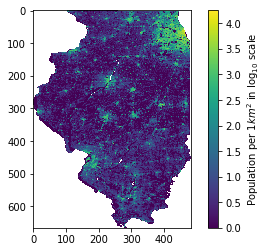

In [9]:
data[data == raster_ds.nodata] = np.nan
data[data == 0] = 0.0001
plt.imshow(np.log10(data), vmin=0)
plt.colorbar(label='Population per 1$km^2$ in $\log_{10}$ scale')

To save the raster image back to file:

In [10]:
target_path = './data/ilpop10.tif'    # replace this with the actual path
with rasterio.open(target_path, 'w', **full_metadata) as raster_ds_w:    # use the previously copied metadata
    raster_ds_w.write(data, 1)    # write to the first band

In actual use cases, you may want to edit contents from `full_metadata` accordingly:

In [11]:
full_metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -407649103380480.0,
 'width': 483,
 'height': 666,
 'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'transform': Affine(0.008333333333333345, 0.0, -91.51666666698287,
        0.0, -0.00833333333333333, 42.51666666623275)}

## 6. Reading and writing vector data

One way to think about vector data is that a vector dataset is just a spreadsheet with a column for geolocation (be it point, line, polygon, or multipolygon). This is exactly how vector datasets are represented in GeoPandas.

Here, we will use the following dataset as an example:
> Illinois State Geological Survey (2003). Illinois County Boundaries, Polygons and Lines. Retrieved from https://clearinghouse.isgs.illinois.edu/data/reference/illinois-county-boundaries-polygons-and-lines

To open the shapefile:

In [12]:
vector_ds = gpd.read_file('data/IL_BNDY_County/IL_BNDY_County_Py.shp')
vector_ds.head()    # get a preview of the first few entries

,COUNTY_NAM,CO_FIPS,geometry
0,MCHENRY,111,"POLYGON ((-88.7074185 42.493512, -88.6880874 4..."
1,BOONE,7,"POLYGON ((-88.7074185 42.493512, -88.7074022 4..."
2,OGLE,141,"POLYGON ((-89.68807870000001 42.1994941, -89.6..."
3,WILL,197,"POLYGON ((-88.2614567 41.7243864, -88.2614639 ..."
4,LASALLE,99,"POLYGON ((-88.93884749999999 41.6283587, -88.9..."


To get some metadata of the dataset:

In [13]:
print('CRS: %s' % str(vector_ds.crs))
print('Columns: %s' % str(list(vector_ds.columns)))
print('Number of entries: %d' % vector_ds.shape[0])

CRS: {'init': 'epsg:4269'}
Columns: ['COUNTY_NAM', 'CO_FIPS', 'geometry']
Number of entries: 102


If you want to select, for example, Champaign county of Illinois, whose [GEOID](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) is 17019 (the state of Illinois is 17; Champaign County is 19), you can do the following:

In [14]:
selection = vector_ds[vector_ds['CO_FIPS'] == 19]
assert selection.shape[0] == 1    # there should be one and only one Champaign County
champaign_entry = selection.iloc[0]
champaign_entry

COUNTY_NAM                                            CHAMPAIGN
CO_FIPS                                                      19
geometry      POLYGON ((-88.4600264 40.3984906, -88.4414422 ...
Name: 14, dtype: object

You can obtain its geometry—in this case, it is a polygon—from the "geometry" field:

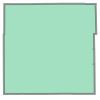

In [15]:
champaign_entry['geometry']    # Jupyter is capable of visualizing polygons automatically

You can apply a number of geometric operations on this shape (which is implemented as a Shapely geometry, so you can find more details reading Shapely documentation). For example:

In [16]:
print('Area: %.2f' % champaign_entry['geometry'].area)
print('Centroid: %s' % str(champaign_entry['geometry'].centroid))
print('The centroid of the polygon is within the polygon:',
          champaign_entry['geometry'].centroid.within(champaign_entry['geometry']))
print('Equivalently, the polygon contains the centroid of itself:',
          champaign_entry['geometry'].contains(champaign_entry['geometry'].centroid))
print('The polygon is essentially an ordered list of points. The first point is:',
          champaign_entry['geometry'].exterior.coords[0])

Area: 0.27
Centroid: POINT (-88.1991302854328 40.14001850787667)
The centroid of the polygon is within the polygon: True
Equivalently, the polygon contains the centroid of itself: True
The polygon is essentially an ordered list of points. The first point is: (-88.4600264, 40.3984906)


To save a vector GeoDataFrame to file, simply do the following:

In [17]:
target_path = './data/IL_BNDY_County/IL_BNDY_County_Py.shp'    # replace this with the actual path
vector_ds.to_file(target_path)

/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


The syntax of GeoPandas is almost identical to that of Pandas. If you are not familiar with Pandas, please refer to the [10 Minutes to Pandas tutorial](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html).

**Note on GeoPackage**: one of the few advantages of ESRI Shapefile over GeoPackage is that ESRI allows the entries to have different geometry types—GeoPackage doesn't. If we were to use a larger county boundary dataset for the entire CONUS, most counties will be polygon, but some of them will be multipolygon (ie. a group of polygons)—because some counties next to lakes or oceans may have islands in them. If you want to save it as `.gpkg` file, you will have to either drop the smaller parts of each county, or convert all polygons to multipolygons.

## 7. Data interoperability

Iteroperability is the ability of different datasets to work together seamlessly. We seldom use a single dataset alone—most of the times we use multiple datasets to produce something meaningful; therefore working with data in differnt formats (vector vs. raster, different CRS, resolution, etc) is essential.

### 7.1. Reprojecting vector dataset
Reprojecting a vector dataset is easy—it is essentially a unit conversion from one CRS to another. With GeoPandas, you can use the `.to_crs` of a dataset to reproject it. For example, our previously loaded Illinois county shapefile is in NAD83 (EPSG 4269). If we wanted to reproject it to UTM 16 North (EPSG 32616), we can simply do the following:

Old CRS: {'init': 'epsg:4269'}
New CRS: {'init': 'epsg:32616'}


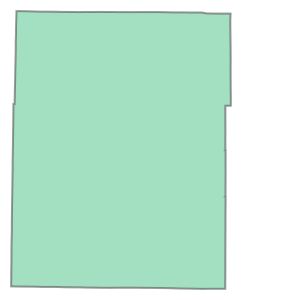

In [18]:
new_vector_ds = vector_ds.to_crs({'init': 'epsg:32616'})
print('Old CRS: %s\nNew CRS: %s' % (vector_ds.crs, new_vector_ds.crs))
new_vector_ds[new_vector_ds['CO_FIPS'] == 19].iloc[0]['geometry']

Note how Champaign County looks differently in a different CRS.

GeoPandas recognizes CRS's in a different ways. In the code block above, I used the EPSG code. To do so, you can write the CRS as a dictionary in the following format: `{'init': 'epsg:<your epsg code>'}`. You can also use PROJ.4 strings; in the case above, we could have used the equavalent PROJ.4 specification of UTM 16 North, "+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs ", and the result would have been the same, except for the representation of the CRS.

Old CRS: {'init': 'epsg:4269'}
New CRS: +proj=utm +zone=16 +datum=WGS84 +units=m +no_defs 


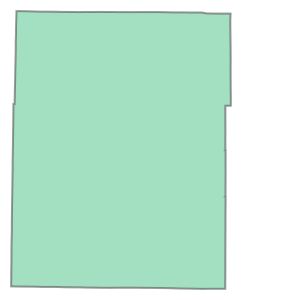

In [19]:
new_vector_ds = vector_ds.to_crs('+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs ')
print('Old CRS: %s\nNew CRS: %s' % (vector_ds.crs, new_vector_ds.crs))
new_vector_ds[new_vector_ds['CO_FIPS'] == 19].iloc[0]['geometry']

### 7.2. Warping raster dataset
Reprojecting a raster is slightly more complicated. As we discussed, raster images are essentially grids overlayed on the earth's surface. Therefore, "reprojecting" is no longer the simple conversion of coordinates. We need to specify which where the new grid will be on the earth's surface, as well as the CRS that the new grid will be in.

That being said, the georeferencing information of a raster dataset can still be faithfully represented by just two things: the CRS and the transformation. Therefore, if we know the source CRS, the source transformation, the target CRS, and the target transformation, we will be in good shape.

We call this process "warping." Instead of reprojecting a dataset, it's probably easier to think warping of an image resempling process—you provide the resampler with a source image along with its georeferencing metadata, you tell the resampler what's your desired output format (ie. CRS and translation), and the resampler gives you a differently sampled image.

The resampling nature of the warping operation dictates that you need to specify a resampler. That is, what the program should do when the pixel in the old grid and the pixel in the new pixel inevitably misalign. Some common resampling methods include:
- Nearest neighbor: the value of a pixel in the new mesh grid is the value of the pixel in the old mesh grid that is the closest to it.
- Average: computes the average of all non-NODATA contributing pixels.
- Bilinear: bilinear interpolation.

The best resampling method to use really depends on your application. For example, if you are operating at a high-enough spatial resolution and the new mesh grid has roughly the same resolution as the old one, you probably do not want to use average because it will essentially become a gaussian filter and will blur your data. If you want to warp a discrete-variable dataset (such as CDL), you may want to stick with nearest neighbor since no matter what you do to enum labels (be it interpolation, averaging, etc), it will make no sense—the only way to go is just to preserve the exact same set of values.

In RasterIO, warping is a little bit confusing because you need to supply RasterIO with the destination array. To initaliza the destination array, we need to know the pixel size of the destination array. Luckily, RasterIO provides a function, `rasterio.warp.calculate_default_transform`, that calculates the transformation and pixel dimension of the target image. For example, if we want to reproject the already-loaded Illinois population density dataset to UTM 16 North:

In [20]:
# Import the `rasterio.warp` submodule
import rasterio.warp

# Calculate the transformation and geometry of the target image
dst_crs = {'init': 'epsg:32616'}
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    src_crs=raster_ds.crs,
    dst_crs=dst_crs,
    width=raster_ds.width,
    height=raster_ds.height,
    bottom=raster_ds.bounds.bottom,
    right=raster_ds.bounds.right,
    top=raster_ds.bounds.top,
    left=raster_ds.bounds.left,
)
print('Size in old CRS: %d by %d\nSize in new CRS: %d by %d'
          % (raster_ds.height, raster_ds.width, dst_height, dst_width))

Size in old CRS: 666 by 483
Size in new CRS: 729 by 421


Note that the size of the images are slightly different in different CRS's. This is to be expected since the mapping distortions are different.

Now we can create an empty array for the destination image:

In [21]:
dst_img = np.zeros((dst_height, dst_width), dtype='float32')

Finally, we can warp/reproject the image using `rasterio.warp.reproject`:

In [22]:
rasterio.warp.reproject(
    source=data,    # this is the previously loaded image
    destination=dst_img,    # this is the empty canvas that we just created
    src_transform=raster_ds.transform,
    src_crs=raster_ds.crs,
    src_nodata=raster_ds.nodata,
    dst_transform=dst_transform, 
    dst_crs=dst_crs,
    dst_nodata=raster_ds.nodata,    # we use the same special NODATA label
    resampling=rasterio.warp.Resampling.nearest
)

We can visualize the old and new raster images side by side:

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


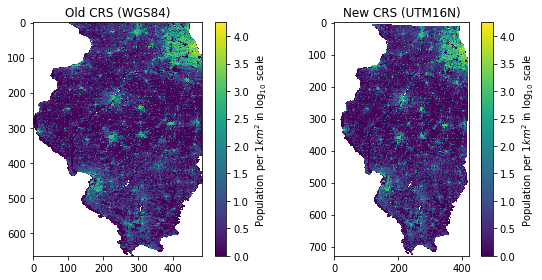

In [23]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.log10(data), vmin=0)
plt.colorbar(label='Population per 1$km^2$ in $\log_{10}$ scale')
plt.title('Old CRS (WGS84)')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(dst_img), vmin=0)
plt.colorbar(label='Population per 1$km^2$ in $\log_{10}$ scale')
plt.title('New CRS (UTM16N)')

plt.tight_layout()

### 7.3. Clipping raster dataset using vector dataset

It's often useful to clip a part of a raster dataset using a vector shape. This is easily achieved with RasterIO's `rasterio.mask` submodule. For example, if we want to clip Champaign County out of the Illinois population density map from the section above:

In [24]:
# Import the `rasterio.mask` submodule
import rasterio.mask

with rasterio.open('./data/ilpop10.tif') as raster_ds:
    # Reproject the Illinois county boundary shapefile to WGS84, matching the CRS of the raster image
    vector_ds_reproj = vector_ds.to_crs(raster_ds.crs)

    # Select the polygon of Champaign County
    champaign_polygon = vector_ds_reproj[vector_ds_reproj['CO_FIPS'] == 19].iloc[0]['geometry']

    # Clip the Champaign portion of the raster image
    champaign_pop_density, champaign_trans = rasterio.mask.mask(
        dataset=raster_ds,
        shapes=[champaign_polygon],
        crop=True,  # reduce the bounding box to the minimal bounding box containing Champaign
        filled=False,  # set pixels outside Champaign but inside the bounding box to NODATA
        all_touched=True,  # include all pixels that touch Champaign, instead of only those whose centroids are inside
    )
print('Array dimension:', champaign_pop_density.shape)

Array dimension: (1, 64, 65)


Now we have the image for Champaign County's population density as well as the 6-tuple transformation of the image clip. Note that the image's dimension is (1, height, width)—this is because raster datasets can have multiple bands (there's only one in our case). We can use the `.squeeze` method of an NumPy array to reshape it to a 2D array.

Note that we set the `shapes` parameter as _a list_ of polygons (in our case it's just one polygon). `rasterio.mask.mask` accepts an interable object (list, tuple, etc) of polygons. If the geometry was a multipolygon, it would have already been an iterable object of polygons, so we could use it directly.

Let's visualzie the image:

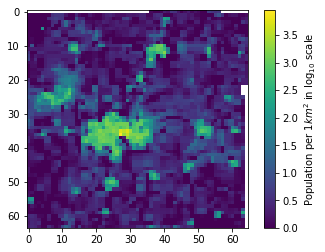

In [25]:
champaign_pop_density = champaign_pop_density.squeeze()
plt.imshow(np.log10(champaign_pop_density), vmin=0)
plt.colorbar(label='Population per 1$km^2$ in $\log_{10}$ scale')

We can save it to disk as we did in section 5:

In [26]:
meta = full_metadata.copy()   # reuse most items in the original dataset's metadata
meta.update({    # we do need to update a few of them, though
    'transform': champaign_trans,
    'width': champaign_pop_density.shape[1],
    'height': champaign_pop_density.shape[0],
    'crs': dst_crs
})

with rasterio.open('./data/champaign_pop_density.tiff', 'w', **meta) as ds:
    ds.write(champaign_pop_density, 1)

## 8. Visualization
When processing geospatial data, always visually inspect the spatial pattern your data and make sure they make conceptual sense.

There are several standards for visualization. If you are just doing a sanity check, you can use simple, non-reproducable methods. If you are preparing a demostrative figure for things like email communication, research memo, etc, you may want to use more reproducible methods to generate the figures. Once everything is settled and you are ready for publication, publishers may have further requrements (eg. lat/long grids, north arrow, scale bar, etc), and it might be the easiest to generate such maps using a desktop application instead of visualization scripts.

In this section, I will introduce some very easy methods of visualizing data. I use these visualization tools daily.


### 8.1. Visualization with QGIS
QGIS is a desktop application for visualizing and analyzing geospatial data, both raster and vector. I like to use it as a pure visualization too, a lot. The advantage of QGIS is that it has a nice GUI and is quite powerful in functionality, so if you want to display something quickly, or if you want advanced map elements such as north arrow, scale bar, etc., it's much easier to do it in QGIS than to write a script that does that. The disadvantage of it is that because it's a GUI application, you visualization isn't exactly reproducible, and you can't automate your configurations.


### 8.2. Visualization with GeoPandas
If you want to visualize vector data, GeoPandas has a nice visualization tool built into it. It's not as powerful/customizable as QGIS or plain Matplotlib, but it's got the basic functionalities. Taking our previously loaded Illinois counties dataset for example, if we want to simply plot the geometries of the entries, a single line of code will do the job:

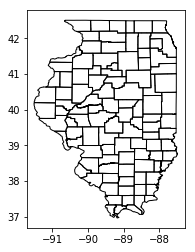

In [27]:
vector_ds.plot(edgecolor='black', facecolor='none')

You can also assign different colors to the geometries based on the values of a single column of the dataset. For example, if we want to draw the same map, but with colors representing the area of the counties:

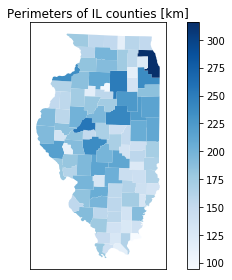

In [28]:
# Add a column called "PERIMETER" to the dataset -- it's the length of the county's boundary
vector_ds_utm16n = vector_ds.to_crs({'init': 'epsg:32616'})    # use UTM16N so the unit is meter
vector_ds_utm16n['PERIMETER'] = vector_ds_utm16n['geometry'].exterior.length / 1000
vector_ds_utm16n.plot(column='PERIMETER', legend=True, cmap='Blues')
plt.title('Perimeters of IL counties [km]')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

The visualization tool of GeoPandas uses Matplotlib as the backend. Therefore, you can use Matplotlib figure/axes syntax—just tell the `<GeoDataFrame>.plot` method which axes to plot on by setting the `ax` parameter:

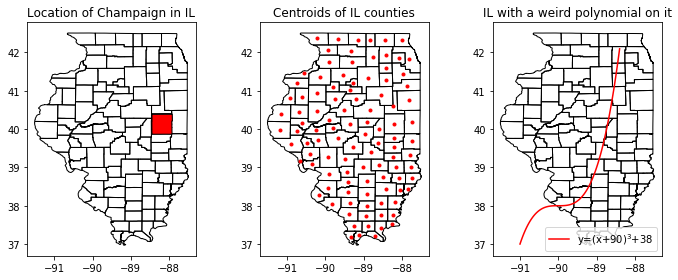

In [29]:
plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 3, 1)
# You can overlay multiple plots
vector_ds.plot(edgecolor='black', facecolor='none', ax=ax)
vector_ds[vector_ds['CO_FIPS'] == 19].plot(edgecolor='black', facecolor='red', ax=ax)
plt.title('Location of Champaign in IL')

ax = plt.subplot(1, 3, 2)
# You can plot different types of data (points, lines, polygons, ...)
vector_ds.plot(edgecolor='black', facecolor='none', ax=ax)
vector_ds_centroids = vector_ds.copy()
vector_ds_centroids['geometry'] = vector_ds_centroids['geometry'].centroid    # replace polygons with their centroids
vector_ds_centroids.plot(marker='.', facecolor='red', ax=ax)
plt.title('Centroids of IL counties')

ax = plt.subplot(1, 3, 3)
# Or indeed you can do whatever you want with it using matplotlib
vector_ds.plot(edgecolor='black', facecolor='none', ax=ax)
x = np.linspace(-91, -88.4, 100)
y = (x + 90) ** 3 + 38
ax.plot(x, y, label='y=(x+90)$^3$+38', color='red')
plt.legend(loc='lower right')
plt.title('IL with a weird polynomial on it')

plt.tight_layout()

### 8.3. Visualization with Matplotlib
Visualizing raster datasets with Matplotlib is easy. Raster datasets are essentially images, so you can plot them the same way you plot any picture—ie. using Matplotlib's `imshow` function. Previous sections of this tutorial have already demostrated how to do that. Note that colormap matters. Selecting the color map properly significantly enhances the communicative power of your visualization. If you are plotting things like crop yield, you may want to use the "spectral" colormap with red color representing low yield and blue color representing high yield. If you are visualizing temperature, you may want to use the same colormap, but inverted. If you are visualizing something of a bidirectional nature, for example, the yield difference of one year compared to another, you can use a blue-white-red color map with blue representing positive difference, red representing negative difference, and white being zero.

If you are trying to visualize vector datasets with Matplotlib, you may find the [Basemap](https://matplotlib.org/basemap/) tookit of Matplotlib useful. It's slightly harder to get started with, though.